## TF-IDF

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:

import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [3]:
#Import Dataset

df=pd.read_csv('/content/gdrive/My Drive/NLP/spam.tsv', delimiter="\t")

In [4]:
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [5]:
df.isnull().sum() # No nulls

label      0
message    0
length     0
punct      0
dtype: int64

In [6]:
df["label"].value_counts()  #Unbalanced data

ham     4825
spam     747
Name: label, dtype: int64

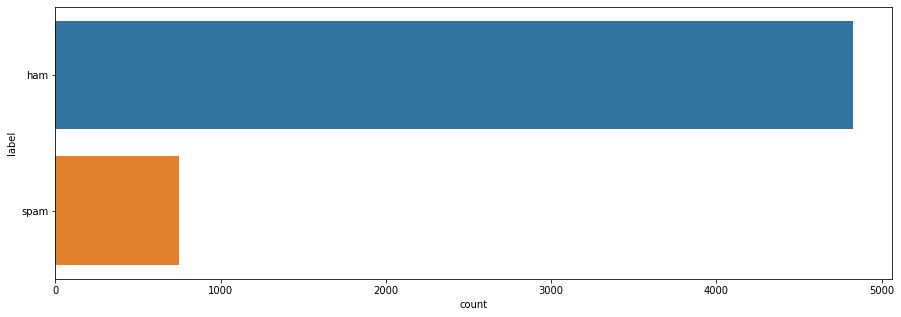

In [7]:
plt.figure(figsize=(15,5))
sns.countplot(y='label', data=df)
plt.show()

In [8]:
cols_to_drop = ['length', 'punct']

for col in cols_to_drop:
  del df[col]

In [9]:
ham_text = df[df.label=="ham"].message
spam_text = df[df.label=="spam"].message

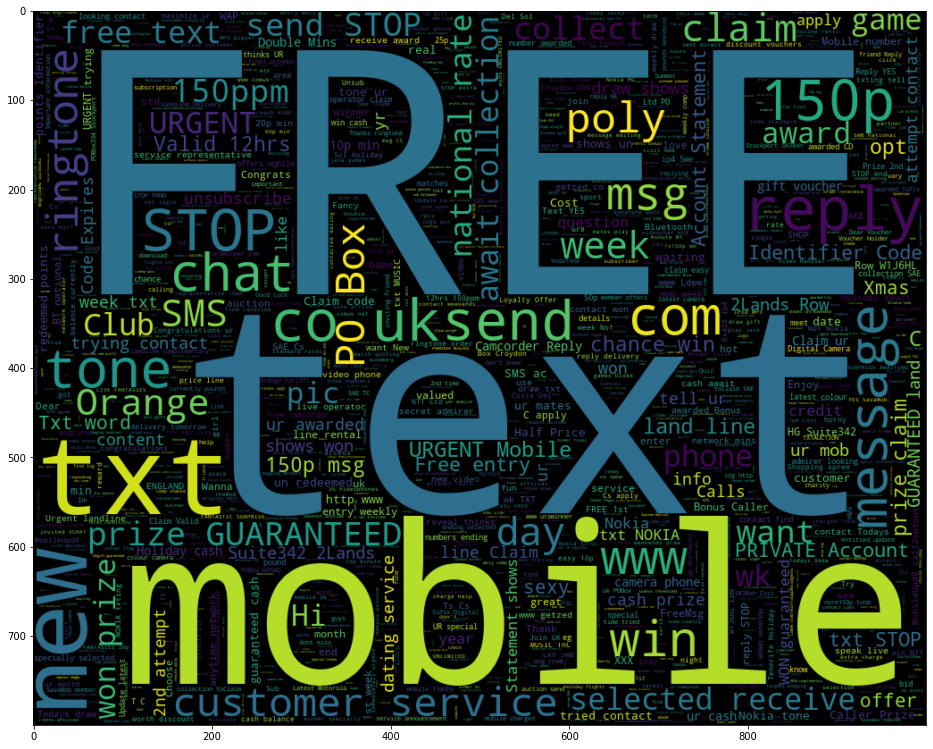

In [10]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc_spam=WordCloud(min_font_size=3, max_words=3000, width=1000, height=800,
             stopwords = STOPWORDS).generate(str(' '.join(spam_text)))
plt.imshow(wc_spam, interpolation='bilinear')

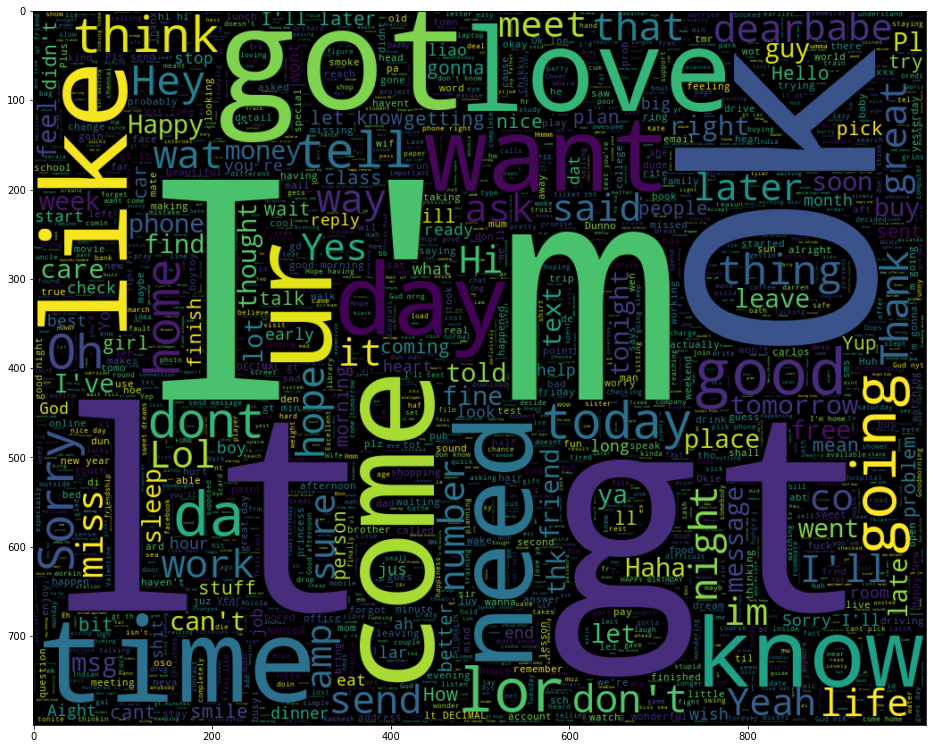

In [11]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc_ham=WordCloud(min_font_size=3, max_words=3000, width=1000, height=800,
             stopwords = STOPWORDS).generate(str(' '.join(ham_text)))
plt.imshow(wc_ham, interpolation='bilinear')

In [12]:
punctuation = string.punctuation
nlp=spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser=English()

def spacy_tokenizer(sentence):
  mytokens = parser(sentence)
  mytokens = [word.lemma_.lower().strip() if word.lemma_ != '-PRON.' else word.lower_ for word in mytokens]
  mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
  return mytokens

class predictors(TransformerMixin):
  def transform(self, X, **transform_params):
    return [clean_text(text) for text in X]

  def fit(self, X, y=None, **fit_params):
    return self

  def get_params(self, deep=True):
    return {}

def clean_text(text):
  return text.strip().lower()

In [13]:
df['message'] = df['message'].apply(clean_text)

In [14]:
cv=TfidfVectorizer(max_features=100)
x = cv.fit_transform(df['message'])

In [15]:
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df["label_"] = df["label"].apply(lambda x: 0 if x=="ham" else 1)
df.drop(["message", "label"], axis=1, inplace=True)
main_df = pd.concat([df1, df], axis=1)


In [17]:
main_df.head()

,about,all,am,and,any,are,as,at,back,be,but,by,call,can,come,da,day,did,do,don,dont,for,free,from,get,go,going,good,got,gt,have,he,her,hi,home,how,if,in,is,it,...,only,or,our,out,please,pls,reply,see,send,she,so,sorry,still,stop,take,tell,text,that,the,then,there,they,think,this,time,to,today,txt,up,ur,want,was,we,what,when,will,with,you,your,label_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.455765,0.0,0.0,0.471721,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.329765,0.0,0.0,...,0.480901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.479318,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.399787,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.279478,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.425878,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.628489,0.0,0.430919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.648092,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.761562,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.40687,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.788466,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.418879,0.0,0.0,0.193181,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3, oob_score=True, n_estimators=100, criterion='entropy')
model = rfc.fit(X_train, y_train)

In [20]:
pred=rfc.predict(X_test)

In [21]:
score=accuracy_score(y_test, pred)
score

0.972488038277512

In [22]:
print('Classification Report\n')
print(classification_report(y_test, pred))

Classification Report

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1450
           1       0.95      0.84      0.89       222

    accuracy                           0.97      1672
   macro avg       0.96      0.92      0.94      1672
weighted avg       0.97      0.97      0.97      1672



In [23]:
print('Confusion Matrix\n')
print(confusion_matrix(y_test, pred))

Confusion Matrix

[[1440   10]
 [  36  186]]
